# Install Libraries if Needed (Only Run Once)

In [ ]:
!pip install -U deepxde
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install -U tensorflow
!pip install -U "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.
!pip install ipympl


# Import Libraries

In [132]:
# Interactive Plotting

# for jupyter notebooks
# %matplotlib notebook 

# for jupyter labs
%matplotlib widget 

In [133]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import io
import re

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint
import matplotlib.tri as tri
from mpl_toolkits import mplot3d

# Poisson Equation
$$
\nabla^2 u(x,y) = -1,\quad (x,y) \in \Omega, \\
u(x,y) = 0, \quad (x,y) \in \partial \Omega, \\
\Omega = [-1, 1]^2 \ \backslash \ [0,1]^2
$$

# Define PDE

In [134]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return -dy_xx - dy_yy - 1

# Define Geometry

In [135]:
geom = dde.geometry.Polygon([[0, 0], [1, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]])

# Define BC

In [136]:
def boundary(_, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, lambda x: 0, boundary)

# Define Data (PDE + BC + Geometry)

In [137]:
data = dde.data.PDE(geom, pde, bc, num_domain=2500, num_boundary=500, num_test=1500)

/home/shawngr2/.local/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+508=508. 
  warnings.warn("The balance properties of Sobol' points require "


# Define Network Architecture

In [138]:
net = dde.maps.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")

# Define Model (Data + Net)

In [139]:
model = dde.Model(data, net)

# Train the Model
Here we train the model twice.  Once with Adam optimizer for initial training.  Then again with L-BFGS-B optimizer for finetuning.

In [140]:
model.compile("adam", lr=0.001)
model.train(epochs=50000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.064611 s



/opt/miniconda3/envs/opence-v1.3.1/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/miniconda3/envs/opence-v1.3.1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-11-16 17:55:52.932652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-16 17:55:52.934948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1869] Adding visible gpu devices: 0
202

'compile' took 0.606717 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.07e+00, 2.15e-02]    [1.08e+00, 2.15e-02]    []  
1000      [2.13e-04, 3.09e-03]    [1.48e-04, 3.09e-03]    []  
2000      [1.76e-04, 2.48e-03]    [1.10e-04, 2.48e-03]    []  
3000      [3.07e-04, 1.72e-03]    [2.23e-04, 1.72e-03]    []  
4000      [8.52e-04, 1.31e-03]    [8.68e-04, 1.31e-03]    []  
5000      [1.57e-04, 4.85e-04]    [1.10e-04, 4.85e-04]    []  
6000      [1.56e-04, 3.23e-04]    [1.25e-04, 3.23e-04]    []  
7000      [1.04e-04, 2.30e-04]    [8.70e-05, 2.30e-04]    []  
8000      [8.83e-05, 2.18e-04]    [8.89e-05, 2.18e-04]    []  
9000      [4.71e-05, 1.88e-04]    [4.12e-05, 1.88e-04]    []  
10000     [3.85e-05, 1.79e-04]    [3.48e-05, 1.79e-04]    []  
11000     [8.77e-04, 1.69e-04]    [9.81e-04, 1.69e-04]    []  
12000     [2.78e-05, 1.61e-04]    [2.58e-05, 1.61e-04]    []  
13000     [2.64e-05, 1.56e-04]    [2.44

# Plot Loss and Predictions

Saving loss history to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/loss_Poisson_Lshape.dat ...
Saving training data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/train_Poisson_Lshape.dat ...
Saving test data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/test_Poisson_Lshape.dat ...


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
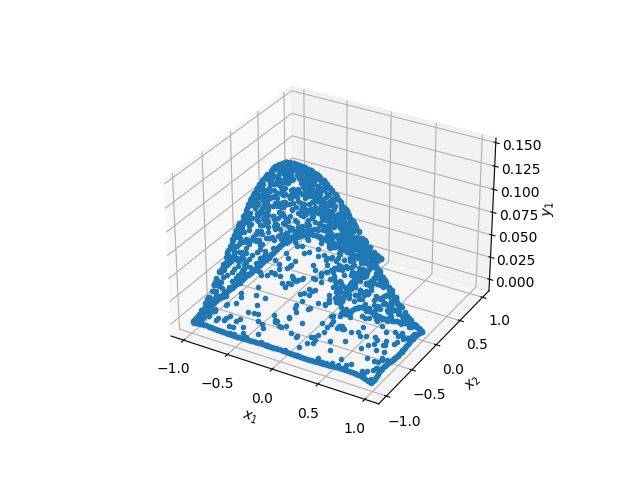

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
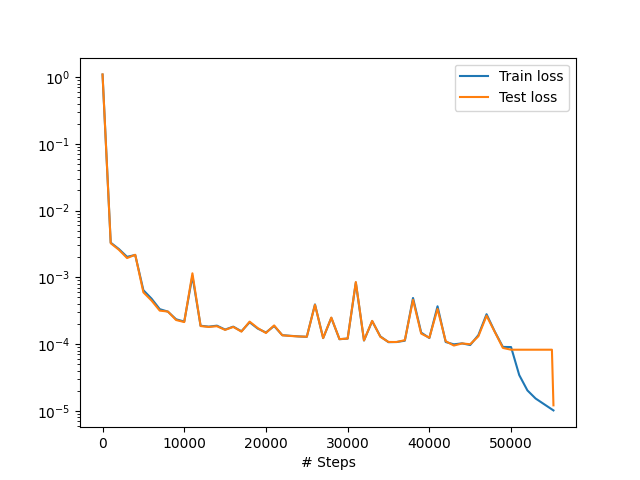

In [141]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname='loss_Poisson_Lshape.dat', train_fname='train_Poisson_Lshape.dat',test_fname='test_Poisson_Lshape.dat')

# Get Predictions

In [142]:
def load_test_data(file='dataset/Poisson_Lshape.npz'):
    data = np.load(file)
    X_test = data['X_test']
    y_test = data['y_ref']
    return X_test, y_test

In [143]:
file = 'dataset/Poisson_Lshape.npz'
X_test, y_test = load_test_data(file)

# Predict on Test Data

In [144]:
y_pred = model.predict(X_test)

# Evaluate on Test Data

In [145]:
not_nan = ~np.isnan(y_test[:,0])

print("L2 relative error:", dde.metrics.l2_relative_error(y_test[not_nan], y_pred[not_nan]))

L2 relative error: 0.11642655467666481


# Plot Results

In [146]:
not_nan

array([ True,  True,  True, ..., False, False, False])

In [147]:
X = X_test[not_nan,0]
Y = X_test[not_nan,1]
Y_test = y_test[not_nan,0]
Y_pred = y_pred[not_nan,0]


In [148]:
triang = tri.Triangulation(X, Y)
x_triang = X[triang.triangles].mean(axis=1)
y_triang = Y[triang.triangles].mean(axis=1)
zero = np.zeros_like(x_triang)
triang.set_mask(np.greater(x_triang,zero) & np.greater(y_triang,zero))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
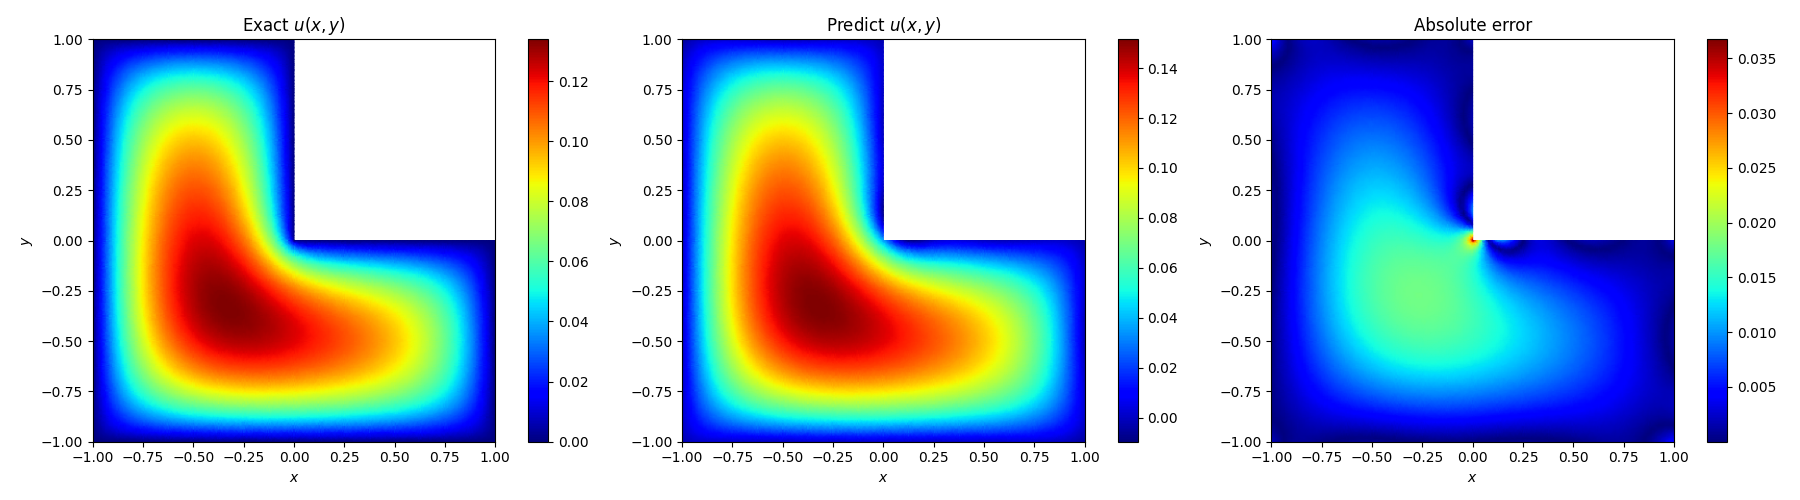

In [149]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
tpc = plt.tripcolor(triang, Y_test, cmap='jet', shading='gouraud')
plt.colorbar(tpc)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Exact $u(x,y)$')
plt.axis('square')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.tight_layout()
# plt.axis('off')

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
tpc = plt.tripcolor(triang, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar(tpc)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Predict $u(x,y)$')
plt.axis('square')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.tight_layout()
# plt.axis('off')

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
tpc = plt.tripcolor(triang, abs(Y_pred - Y_test), cmap='jet', shading='gouraud')
plt.colorbar(tpc)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.axis('square')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.tight_layout()
# plt.axis('off')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
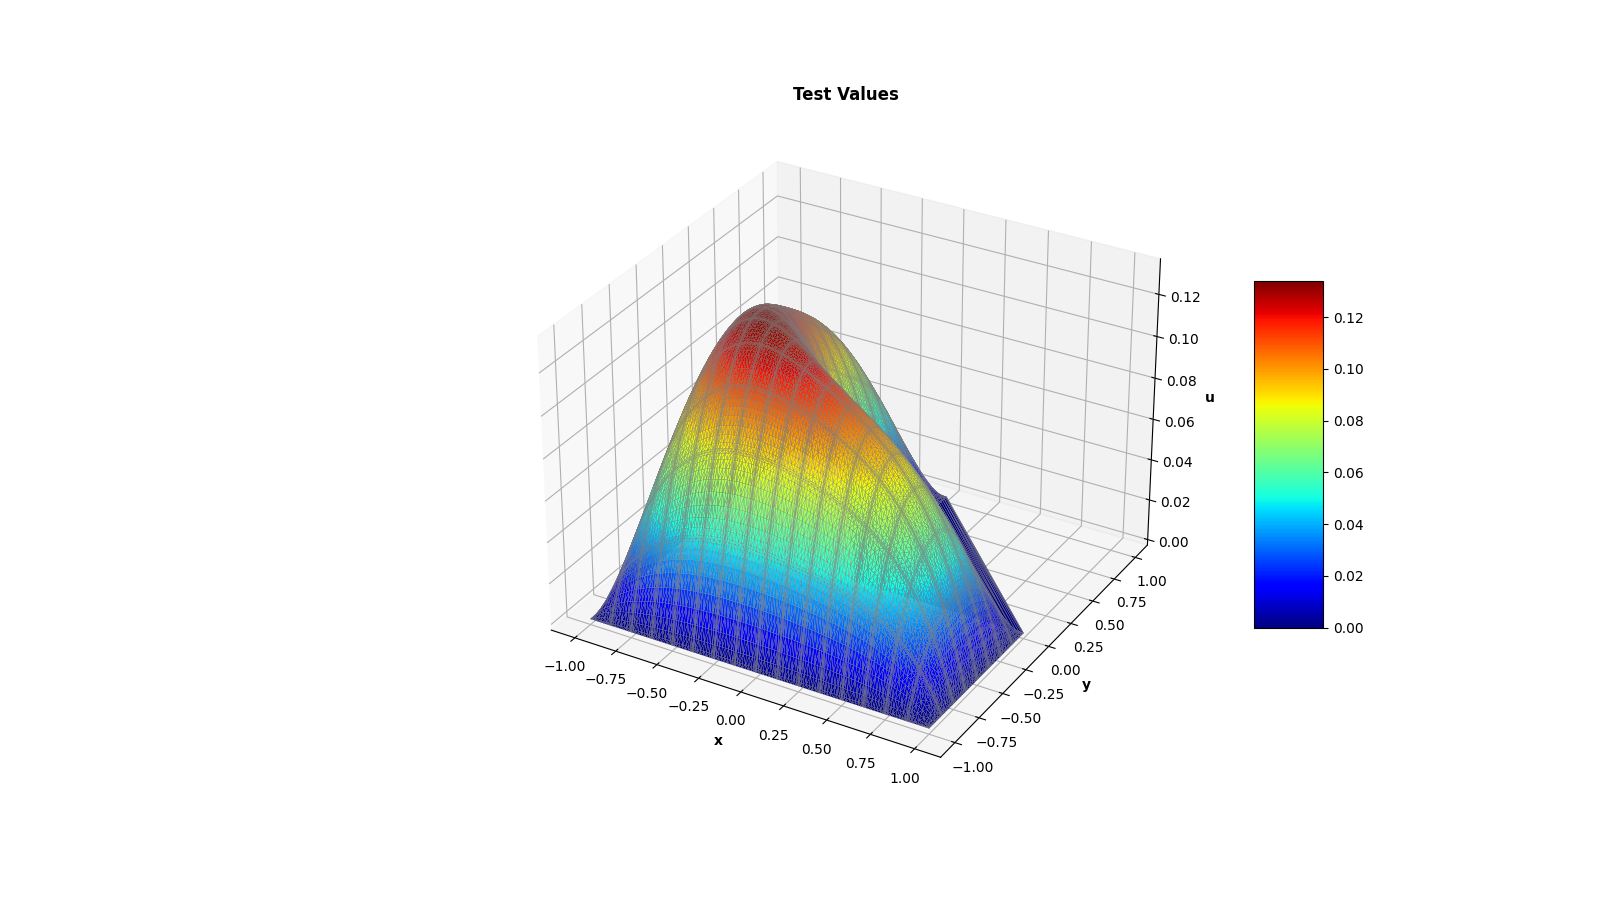

In [150]:
fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
trisurf = ax.plot_trisurf(X, Y, Y_test,
                         cmap = 'jet',
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey') 
fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.set_title('Test Values', fontweight='bold')
# Adding labels
ax.set_xlabel('x', fontweight ='bold')
ax.set_ylabel('y', fontweight ='bold')
ax.set_zlabel('u', fontweight ='bold')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
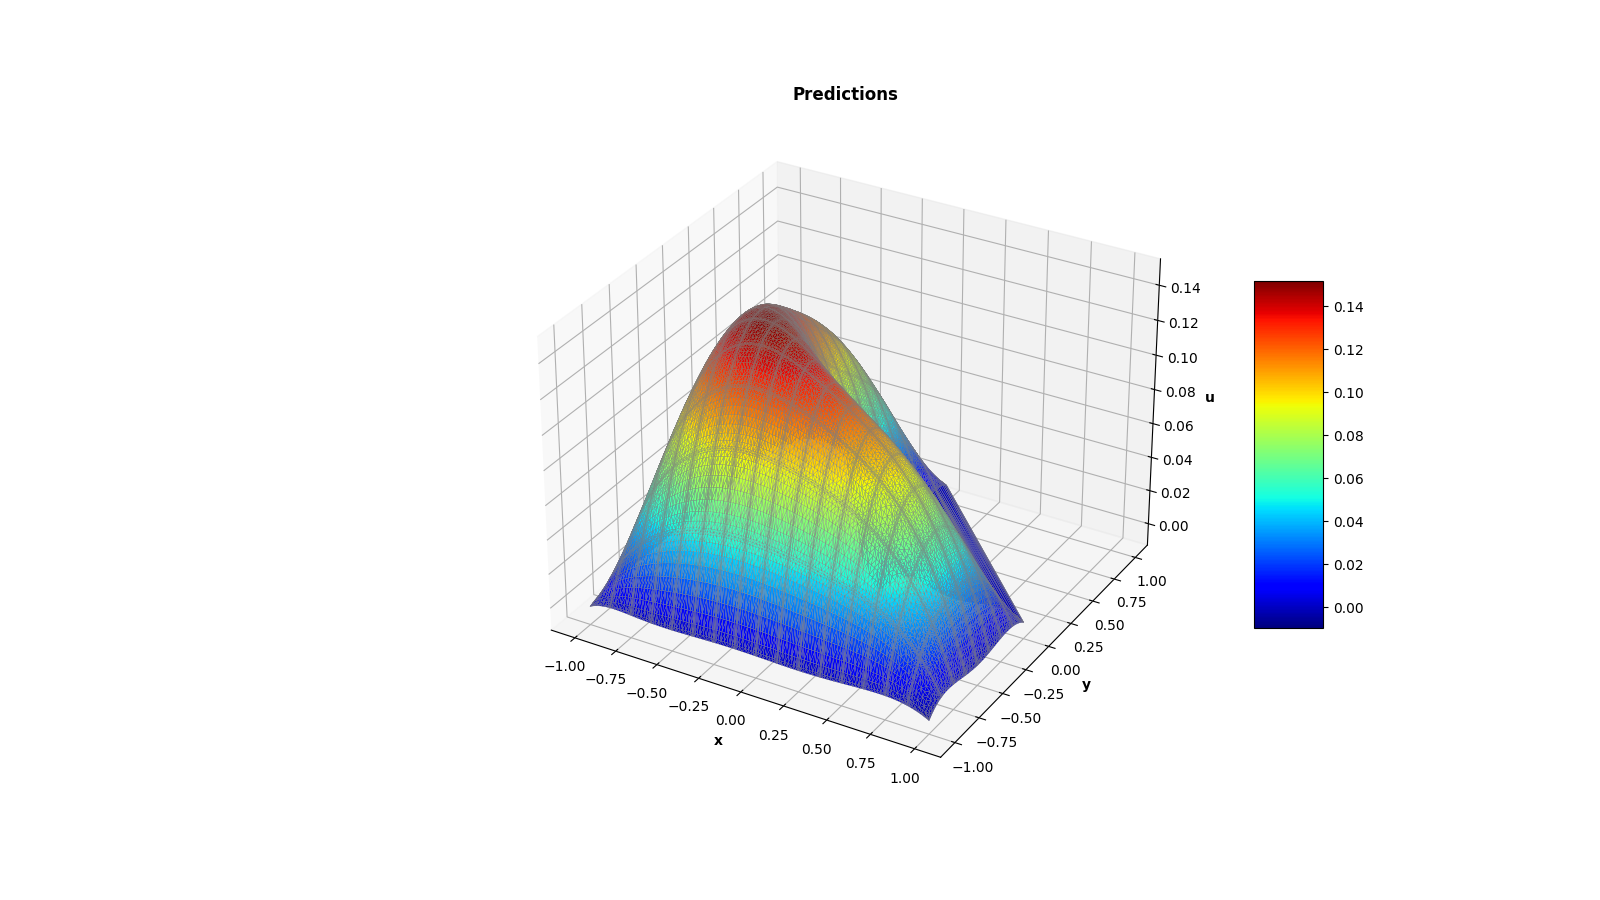

In [151]:
fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
trisurf = ax.plot_trisurf(X, Y, Y_pred,
                         cmap = 'jet',
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey') 
fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.set_title('Predictions', fontweight='bold')
# Adding labels
ax.set_xlabel('x', fontweight ='bold')
ax.set_ylabel('y', fontweight ='bold')
ax.set_zlabel('u', fontweight ='bold')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
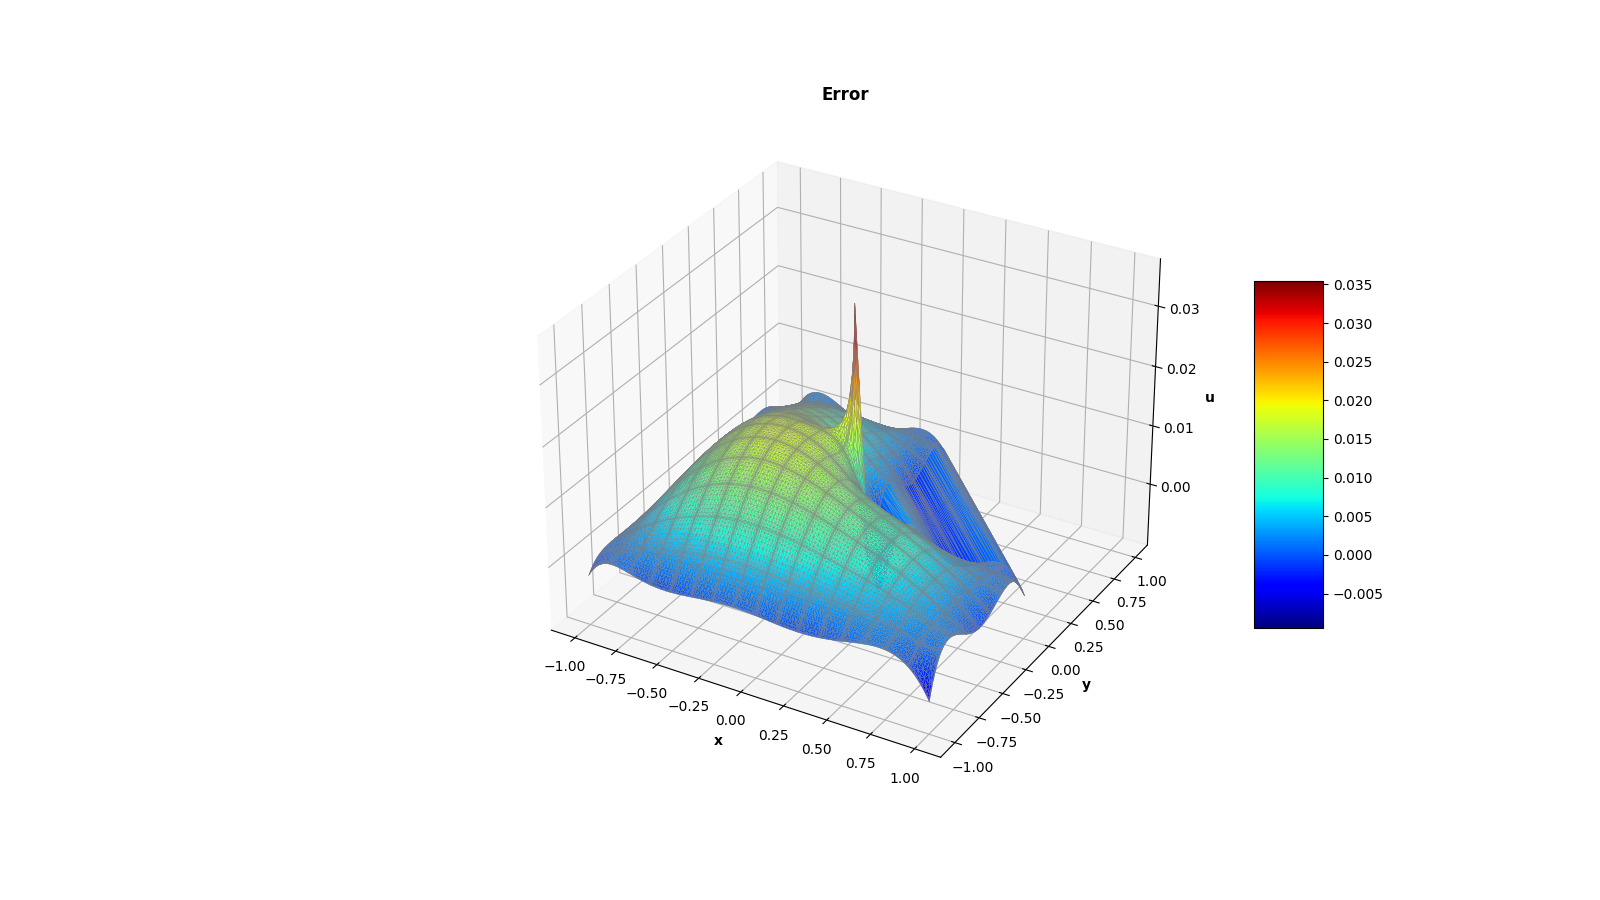

In [152]:
fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
trisurf = ax.plot_trisurf(X, Y, Y_pred - Y_test,
                         cmap = 'jet',
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey') 
fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.set_title('Error', fontweight='bold')
# Adding labels
ax.set_xlabel('x', fontweight ='bold')
ax.set_ylabel('y', fontweight ='bold')
ax.set_zlabel('u', fontweight ='bold')
plt.show()